In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.style.use(['dark_background'])

In [2]:
def date_time_parser(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

# Single Asset

In [3]:
ticker = "spy"
df = pd.read_csv(f'../data/ETFs/{ticker}.us.txt', header=0, parse_dates=[0], date_parser=date_time_parser)

In [4]:
df.index = df['Date']

In [5]:
df.head(10)

Date    Open    High     Low   Close    Volume  OpenInt
Date                                                                    
2005-02-25 2005-02-25  104.77  106.00  104.68  105.79  70221808        0
2005-02-28 2005-02-28  105.55  105.68  104.56  105.08  79695344        0
2005-03-01 2005-03-01  105.22  105.87  105.22  105.62  54607412        0
2005-03-02 2005-03-02  105.21  106.22  105.10  105.57  73733090        0
2005-03-03 2005-03-03  105.99  106.20  105.15  105.61  71286823        0
2005-03-04 2005-03-04  106.31  107.01  106.10  106.93  64483624        0
2005-03-07 2005-03-07  106.86  107.38  106.62  106.97  50288014        0
2005-03-08 2005-03-08  106.87  107.15  106.36  106.55  51274973        0
2005-03-09 2005-03-09  106.25  106.52  105.38  105.39  84491113        0
2005-03-10 2005-03-10  105.40  105.85  104.89  105.62  74962248        0

In [6]:
#Calculate log returns
price = df['Close']
log_rs = price.apply(np.log).diff(1).fillna(0)

In [7]:
# short-term moving average window - long-term moving average window
w1 = 5
w2 = 22
ma_x = price.rolling(w1).mean() - price.rolling(w2).mean()

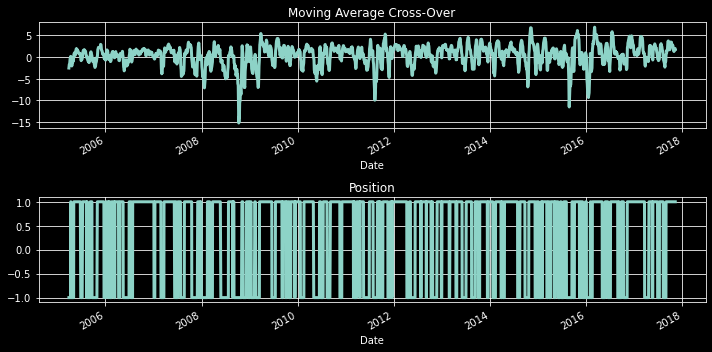

In [8]:
# translate the signal to trading positions
trade_position = ma_x.apply(np.sign)

fig, ax = plt.subplots(2,1)
ma_x.plot(ax=ax[0], title='Moving Average Cross-Over')
trade_position.plot(ax=ax[1], title='Position')
plt.show()

In [9]:
my_returns = trade_position.shift(1)*log_rs #shift 

In [ ]:
plt.plot

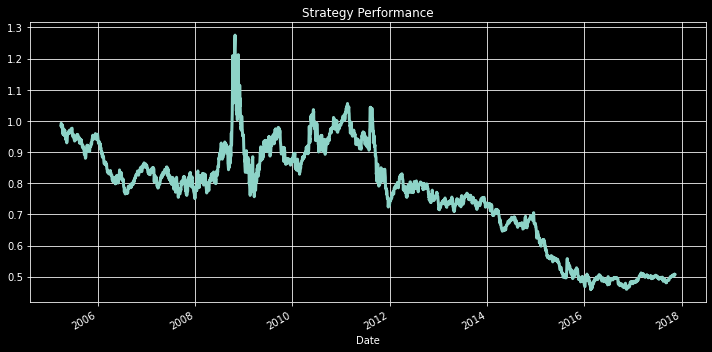

In [10]:
my_returns.cumsum().apply(np.exp).plot(title="Strategy Performance")

# Multiasset

In [11]:
tickers = ['gcc', 'spy', 'tipx']

In [12]:
dfs = []
date_range = []
for ticker in tickers:
    df = pd.read_csv(f"../data/ETFs/{ticker}.us.txt",  header=0, parse_dates=[0], date_parser=date_time_parser, usecols=['Date', 'Close'])
    date_range.append((min(df["Date"]), max(df["Date"])))
    df.index = df["Date"]
    df.rename(columns={"Date": f"Date_{ticker}", "Close": f"Close_{ticker}"}, inplace=True)
    dfs.append(df)
df = pd.concat(dfs, axis=1)

In [14]:
latest_start_date = max([o[0] for o in date_range])
earliest_end_date = min([o[1] for o in date_range])

tmp_dfs = []
for ticker in tickers:
    slice_df = df[(df.index > latest_start_date) & (df.index < earliest_end_date)]
    
    tmp_dfs.append(slice_df[f"Close_{ticker}"])

In [15]:
train_df = pd.concat(tmp_dfs, axis=1)

In [16]:
train_df.fillna(method="ffill", inplace=True)

In [17]:
log_rs = train_df.apply(np.log).diff(1).fillna(0)

In [18]:
w1 = 5
w2 = 22
ma_x = train_df.rolling(w1).mean() - train_df.rolling(w2).mean()

In [19]:
ma_x

Close_gcc  Close_spy  Close_tipx
Date                                        
2013-06-06        NaN        NaN         NaN
2013-06-07        NaN        NaN         NaN
2013-06-10        NaN        NaN         NaN
2013-06-11        NaN        NaN         NaN
2013-06-12        NaN        NaN         NaN
...               ...        ...         ...
2017-11-03   0.151688   1.562818    0.032045
2017-11-06   0.170870   1.792364    0.039136
2017-11-07   0.195506   1.900909    0.048136
2017-11-08   0.210541   1.990364    0.053136
2017-11-09   0.231814   1.945000    0.055409

[1118 rows x 3 columns]

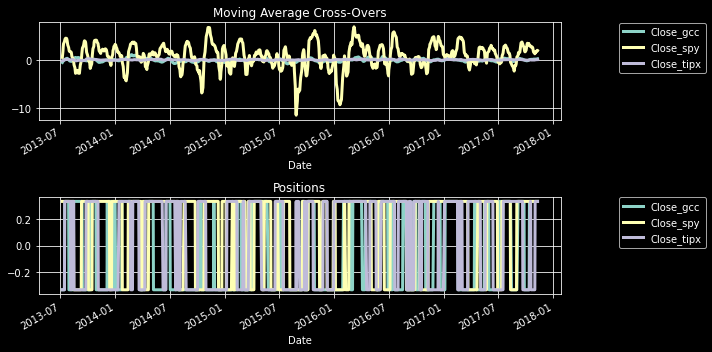

In [20]:
pos = ma_x.apply(np.sign)
pos /= pos.abs().sum(1).values.reshape(-1,1)

fig, ax = plt.subplots(2,1)
ma_x.plot(ax=ax[0], title='Moving Average Cross-Overs')
ax[0].legend(bbox_to_anchor=(1.1, 1.05))
pos.plot(ax=ax[1], title='Positions')
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('tmp.png')

In [21]:
my_returns = pos.shift(1)*log_rs #shift 

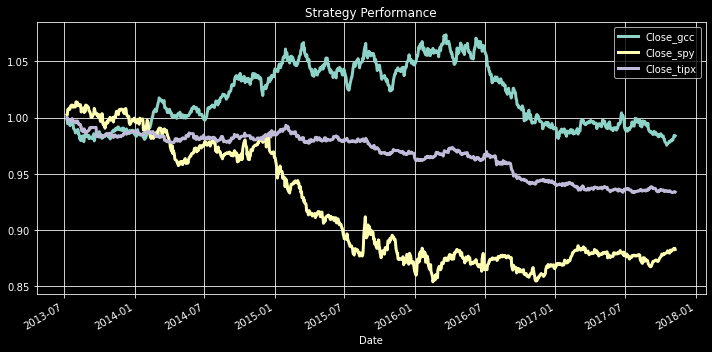

In [22]:
my_returns.cumsum().apply(np.exp).plot(title="Strategy Performance")

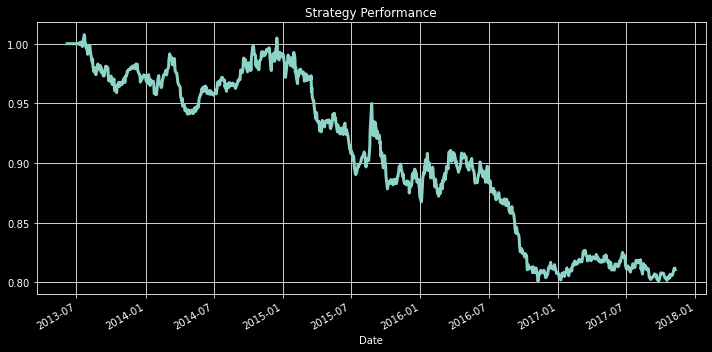

In [23]:
my_returns = (pos.shift(1)*log_rs).sum(1)

my_returns.cumsum().apply(np.exp).plot(title='Strategy Performance')

# Look ahead bias performance

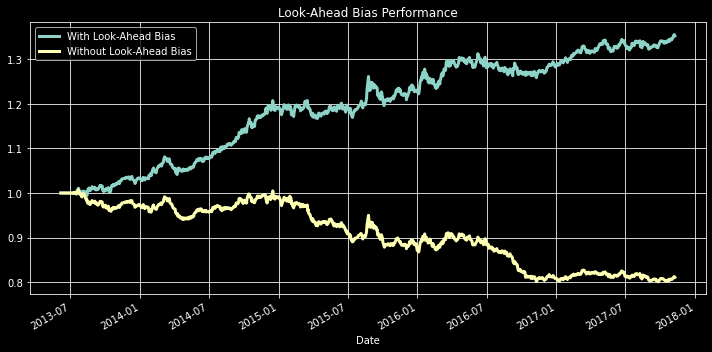

In [24]:
my_rs1 = (pos*log_rs).sum(1)
my_rs2 = (pos.shift(1)*log_rs).sum(1)

my_rs1.cumsum().apply(np.exp).plot(title='Look-Ahead Bias Performance')
my_rs2.cumsum().apply(np.exp).plot()
plt.legend(['With Look-Ahead Bias', 'Without Look-Ahead Bias'])
# rs.mean(1).cumsum().apply(np.exp).plot()
# plt.legend(['my performance', 'benchmark performance'])
plt.savefig('tmp.png')

# Feature Importance Analysis

## Create Features 

### Technical Indicators

In [25]:
ticker = "spy"
df = pd.read_csv(f'../data/ETFs/{ticker}.us.txt', header=0, parse_dates=[0], date_parser=date_time_parser)

In [26]:
def get_technical_indicators(dataset, counter_str):
    dataset['ma7'] = dataset[counter_str].rolling(window=7).mean()
    dataset['ma21'] = dataset[counter_str].rolling(window=21).mean()

    dataset['26ema'] = dataset[counter_str].ewm(span=26).mean()
    dataset['12ema'] = dataset[counter_str].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    dataset['20sd'] = dataset[counter_str].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)

    dataset['ema'] = dataset[counter_str].ewm(com=0.5).mean()
    return dataset

In [27]:
TI_df = get_technical_indicators(df, 'Close')

In [28]:
TI_df.tail(10)

Date    Open    High      Low   Close    Volume  OpenInt  \
3191 2017-10-30  257.07  257.60  256.410  256.75  54260547        0   
3192 2017-10-31  257.18  257.44  256.805  257.15  59437242        0   
3193 2017-11-01  258.04  258.43  257.070  257.49  54173392        0   
3194 2017-11-02  257.41  257.75  256.190  257.59  56424826        0   
3195 2017-11-03  257.77  258.50  257.300  258.45  59578151        0   
3196 2017-11-06  258.30  259.00  258.220  258.85  49529148        0   
3197 2017-11-07  258.97  259.35  258.110  258.67  57218448        0   
3198 2017-11-08  258.47  259.22  258.150  259.11  50277699        0   
3199 2017-11-09  257.73  258.39  256.360  258.17  94537282        0   
3200 2017-11-10  257.73  258.21  257.370  258.09  59862364        0   

             ma7        ma21       26ema       12ema      MACD      20sd  \
3191  256.450000  255.141429  254.141529  255.879555  1.738026  1.229064   
3192  256.455714  255.371429  254.364379  256.075008  1.710629  1.156224   
3193  256.652857  255.591905  254.595906  256.292699  1.696793  1.099599   
3194  256.800000  255.802857  254.817691  256.492284  1.674593  1.146055   
3195  257.251429  255.983333  255.086751  256.793471  1.706720  1.227129   
3196  257.712857  256.196667  255.365510  257.109860  1.744350  1.271207   
3197  257.850000  256.421429  255.610287  257.349881  1.739594  1.309979   
3198  258.187143  256.635238  255.869525  257.620669  1.751144  1.382143   
3199  258.332857  256.785238  256.039931  257.705181  1.665251  1.327391   
3200  258.418571  256.949524  256.191788  257.764384  1.572597  1.270000   

      upper_band  lower_band         ema  
3191  257.599557  252.683300  256.840122  
3192  257.683876  253.058981  257.046707  
3193  257.791103  253.392706  257.342236  
3194  258.094967  253.510747  257.507412  
3195  258.437592  253.529075  258.135804  
3196  258.739081  253.654253  258.611935  
3197  259.041387  253.801471  258.650645  
3198  259.399525  253.870952  258.956882  
3199  259.440020  254.130456  258.432294  
3200  259.489524  254.409524  258.204098

In [29]:
# !conda install -y -c plotly plotly

In [30]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [31]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

## XGBoost

In [32]:
# !conda install -y -c conda-forge xgboost 

In [33]:
import xgboost as xgb

In [34]:
data = TI_df.copy()

In [35]:
data.head(5)

Date    Open    High     Low   Close    Volume  OpenInt  ma7  ma21  \
0 2005-02-25  104.77  106.00  104.68  105.79  70221808        0  NaN   NaN   
1 2005-02-28  105.55  105.68  104.56  105.08  79695344        0  NaN   NaN   
2 2005-03-01  105.22  105.87  105.22  105.62  54607412        0  NaN   NaN   
3 2005-03-02  105.21  106.22  105.10  105.57  73733090        0  NaN   NaN   
4 2005-03-03  105.99  106.20  105.15  105.61  71286823        0  NaN   NaN   

        26ema       12ema      MACD  20sd  upper_band  lower_band         ema  \
0  105.790000  105.790000  0.000000   NaN         NaN         NaN  105.790000   
1  105.421346  105.405417 -0.015929   NaN         NaN         NaN  105.257500   
2  105.492721  105.489169 -0.003552   NaN         NaN         NaN  105.508462   
3  105.514325  105.514684  0.000359   NaN         NaN         NaN  105.550000   
4  105.536512  105.540581  0.004069   NaN         NaN         NaN  105.590165   

   RSI  
0  NaN  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [36]:
data.dropna(inplace=True)

In [37]:
y = data['Close'].shift(1).iloc[1:]

In [38]:
X = data.drop(['Date', 'OpenInt'], axis=1).iloc[1:]

In [39]:
X.head(5)

Open    High     Low   Close     Volume         ma7        ma21  \
21  102.05  102.71  101.27  101.51   83849903  102.240000  104.373810   
22  101.85  102.98  101.72  102.96   72199510  102.197143  104.272857   
23  102.97  103.19  102.68  102.77   74669192  102.180000  104.137143   
24  103.34  103.66  101.85  102.30  111800673  102.244286  103.981429   
25  102.24  102.67  101.70  102.48   82200501  102.322857  103.832381   

         26ema       12ema      MACD      20sd  upper_band  lower_band  \
21  103.692066  102.955448 -0.736618  1.798272  107.970353  100.777266   
22  103.626707  102.956164 -0.670544  1.796870  107.866597  100.679117   
23  103.551366  102.926994 -0.624373  1.794038  107.725219  100.549066   
24  103.442823  102.829029 -0.613794  1.796731  107.574890  100.387967   
25  103.360353  102.774625 -0.585728  1.673037  107.178454  100.486308   

           ema        RSI  
21  101.720824  18.261965  
22  102.546941  35.236938  
23  102.695647  32.600733  
24  102.431882  33.712121  
25  102.463961  29.435484

In [40]:
train_samples = int(X.shape[0] * 0.7)
    
X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

In [41]:
regressor = xgb.XGBRegressor(n_estimators=150, base_score=0.7, colsample_bytree=1, learning_rate=0.05)
xgbModel = regressor.fit(X_train, y_train,
                        eval_set=[(X_test, y_test), (X_train, y_train)])

[0]	validation_0-rmse:197.61539	validation_1-rmse:109.78469
[1]	validation_0-rmse:190.35638	validation_1-rmse:104.32039
[2]	validation_0-rmse:183.49554	validation_1-rmse:99.12865
[3]	validation_0-rmse:176.85945	validation_1-rmse:94.19479
[4]	validation_0-rmse:170.68619	validation_1-rmse:89.50768
[5]	validation_0-rmse:164.69791	validation_1-rmse:85.05360
[6]	validation_0-rmse:158.96233	validation_1-rmse:80.82070
[7]	validation_0-rmse:153.34634	validation_1-rmse:76.79940
[8]	validation_0-rmse:148.17165	validation_1-rmse:72.97784
[9]	validation_0-rmse:142.96343	validation_1-rmse:69.34734
[10]	validation_0-rmse:138.30360	validation_1-rmse:65.89726
[11]	validation_0-rmse:133.55110	validation_1-rmse:62.61880
[12]	validation_0-rmse:129.03763	validation_1-rmse:59.50394
[13]	validation_0-rmse:125.00794	validation_1-rmse:56.54338
[14]	validation_0-rmse:121.18904	validation_1-rmse:53.73069
[15]	validation_0-rmse:117.42801	validation_1-rmse:51.05764
[16]	validation_0-rmse:113.94787	validation_1-rm

[140]	validation_0-rmse:41.31177	validation_1-rmse:0.42286
[141]	validation_0-rmse:41.30640	validation_1-rmse:0.42104
[142]	validation_0-rmse:41.30254	validation_1-rmse:0.41881
[143]	validation_0-rmse:41.29845	validation_1-rmse:0.41678
[144]	validation_0-rmse:41.29486	validation_1-rmse:0.41483
[145]	validation_0-rmse:41.29067	validation_1-rmse:0.41315
[146]	validation_0-rmse:41.28713	validation_1-rmse:0.41109
[147]	validation_0-rmse:41.28272	validation_1-rmse:0.40925
[148]	validation_0-rmse:41.27926	validation_1-rmse:0.40738
[149]	validation_0-rmse:41.27511	validation_1-rmse:0.40626


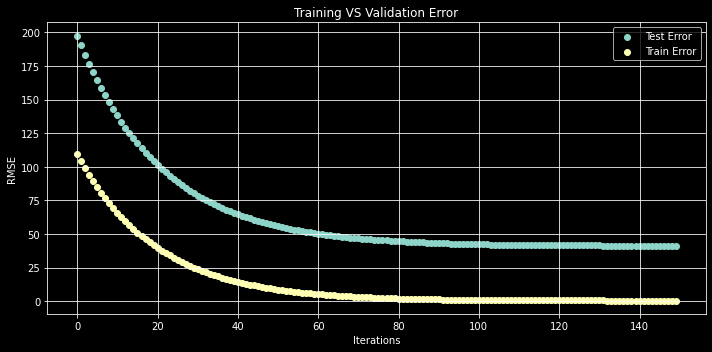

In [42]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(training_rounds, eval_result['validation_0']['rmse'], label='Test Error')
plt.scatter(training_rounds, eval_result['validation_1']['rmse'], label='Train Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

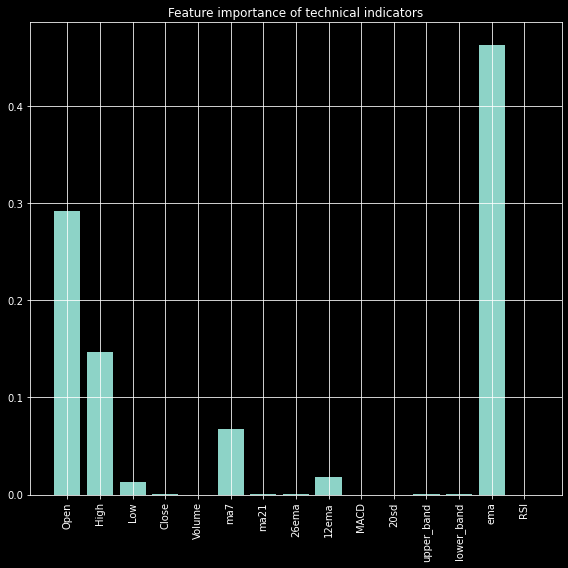

In [43]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], 
        list(xgbModel.feature_importances_), 
        tick_label=X_test.columns)
plt.title('Feature importance of technical indicators')
plt.show()

# Grid Search

## One Hyperparameter

In [44]:
n_estimators = [10, 50, 100, 200, 400]

In [45]:
best = {'rmse': 200,
        'n_estimator': None,
        'model': None}

for n_est in n_estimators:
    regressor = xgb.XGBRegressor(n_estimators=n_est, base_score=0.7, colsample_bytree=1, learning_rate=0.05)
    xgbModel = regressor.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
    rmse = regressor.evals_result()['validation_0']['rmse'][-1]
    if rmse < best['rmse']:
        best['rmse'] = rmse
        best['n_estimator'] = n_est
        best['model'] = regressor

[0]	validation_0-rmse:197.61537	validation_1-rmse:109.78469
[1]	validation_0-rmse:190.35637	validation_1-rmse:104.32039
[2]	validation_0-rmse:183.49554	validation_1-rmse:99.12865
[3]	validation_0-rmse:176.85945	validation_1-rmse:94.19478
[4]	validation_0-rmse:170.68617	validation_1-rmse:89.50768
[5]	validation_0-rmse:164.69791	validation_1-rmse:85.05360
[6]	validation_0-rmse:158.96234	validation_1-rmse:80.82070
[7]	validation_0-rmse:153.34634	validation_1-rmse:76.79940
[8]	validation_0-rmse:148.17165	validation_1-rmse:72.97784
[9]	validation_0-rmse:142.96343	validation_1-rmse:69.34734
[0]	validation_0-rmse:197.61539	validation_1-rmse:109.78469
[1]	validation_0-rmse:190.35637	validation_1-rmse:104.32039
[2]	validation_0-rmse:183.49554	validation_1-rmse:99.12865
[3]	validation_0-rmse:176.85945	validation_1-rmse:94.19478
[4]	validation_0-rmse:170.68617	validation_1-rmse:89.50768
[5]	validation_0-rmse:164.69789	validation_1-rmse:85.05360
[6]	validation_0-rmse:158.96233	validation_1-rmse:80

[79]	validation_0-rmse:44.77881	validation_1-rmse:2.02675
[80]	validation_0-rmse:44.59498	validation_1-rmse:1.93261
[81]	validation_0-rmse:44.42007	validation_1-rmse:1.84354
[82]	validation_0-rmse:44.26374	validation_1-rmse:1.75923
[83]	validation_0-rmse:44.11227	validation_1-rmse:1.67913
[84]	validation_0-rmse:43.96820	validation_1-rmse:1.60348
[85]	validation_0-rmse:43.82037	validation_1-rmse:1.53173
[86]	validation_0-rmse:43.67960	validation_1-rmse:1.46385
[87]	validation_0-rmse:43.54561	validation_1-rmse:1.39959
[88]	validation_0-rmse:43.41804	validation_1-rmse:1.33896
[89]	validation_0-rmse:43.29653	validation_1-rmse:1.28144
[90]	validation_0-rmse:43.18086	validation_1-rmse:1.22709
[91]	validation_0-rmse:43.07286	validation_1-rmse:1.17598
[92]	validation_0-rmse:42.96787	validation_1-rmse:1.12778
[93]	validation_0-rmse:42.86788	validation_1-rmse:1.08214
[94]	validation_0-rmse:42.77457	validation_1-rmse:1.03917
[95]	validation_0-rmse:42.68380	validation_1-rmse:0.99847
[96]	validatio

[119]	validation_0-rmse:41.56054	validation_1-rmse:0.51355
[120]	validation_0-rmse:41.53696	validation_1-rmse:0.50592
[121]	validation_0-rmse:41.51142	validation_1-rmse:0.49867
[122]	validation_0-rmse:41.49916	validation_1-rmse:0.49221
[123]	validation_0-rmse:41.47579	validation_1-rmse:0.48630
[124]	validation_0-rmse:41.46464	validation_1-rmse:0.48027
[125]	validation_0-rmse:41.45524	validation_1-rmse:0.47497
[126]	validation_0-rmse:41.43470	validation_1-rmse:0.47029
[127]	validation_0-rmse:41.42497	validation_1-rmse:0.46534
[128]	validation_0-rmse:41.41701	validation_1-rmse:0.46094
[129]	validation_0-rmse:41.40799	validation_1-rmse:0.45721
[130]	validation_0-rmse:41.39249	validation_1-rmse:0.45351
[131]	validation_0-rmse:41.38555	validation_1-rmse:0.44975
[132]	validation_0-rmse:41.37769	validation_1-rmse:0.44668
[133]	validation_0-rmse:41.36366	validation_1-rmse:0.44388
[134]	validation_0-rmse:41.35655	validation_1-rmse:0.44075
[135]	validation_0-rmse:41.34968	validation_1-rmse:0.438

[58]	validation_0-rmse:51.09661	validation_1-rmse:5.72712
[59]	validation_0-rmse:50.61110	validation_1-rmse:5.44535
[60]	validation_0-rmse:50.19189	validation_1-rmse:5.17765
[61]	validation_0-rmse:49.75157	validation_1-rmse:4.92349
[62]	validation_0-rmse:49.38048	validation_1-rmse:4.68206
[63]	validation_0-rmse:48.98063	validation_1-rmse:4.45275
[64]	validation_0-rmse:48.63878	validation_1-rmse:4.23494
[65]	validation_0-rmse:48.27587	validation_1-rmse:4.02813
[66]	validation_0-rmse:47.96720	validation_1-rmse:3.83179
[67]	validation_0-rmse:47.66424	validation_1-rmse:3.64534
[68]	validation_0-rmse:47.34317	validation_1-rmse:3.46836
[69]	validation_0-rmse:47.06755	validation_1-rmse:3.30032
[70]	validation_0-rmse:46.77589	validation_1-rmse:3.14081
[71]	validation_0-rmse:46.52002	validation_1-rmse:2.98948
[72]	validation_0-rmse:46.25528	validation_1-rmse:2.84583
[73]	validation_0-rmse:46.01279	validation_1-rmse:2.70945
[74]	validation_0-rmse:45.79813	validation_1-rmse:2.58015
[75]	validatio

[198]	validation_0-rmse:41.17135	validation_1-rmse:0.35696
[199]	validation_0-rmse:41.17117	validation_1-rmse:0.35656
[200]	validation_0-rmse:41.17140	validation_1-rmse:0.35593
[201]	validation_0-rmse:41.17073	validation_1-rmse:0.35504
[202]	validation_0-rmse:41.17014	validation_1-rmse:0.35455
[203]	validation_0-rmse:41.17008	validation_1-rmse:0.35359
[204]	validation_0-rmse:41.16991	validation_1-rmse:0.35312
[205]	validation_0-rmse:41.16929	validation_1-rmse:0.35221
[206]	validation_0-rmse:41.16916	validation_1-rmse:0.35195
[207]	validation_0-rmse:41.16398	validation_1-rmse:0.35173
[208]	validation_0-rmse:41.16382	validation_1-rmse:0.35106
[209]	validation_0-rmse:41.16339	validation_1-rmse:0.35013
[210]	validation_0-rmse:41.16363	validation_1-rmse:0.34946
[211]	validation_0-rmse:41.16357	validation_1-rmse:0.34923
[212]	validation_0-rmse:41.16346	validation_1-rmse:0.34859
[213]	validation_0-rmse:41.16364	validation_1-rmse:0.34778
[214]	validation_0-rmse:41.16352	validation_1-rmse:0.347

[337]	validation_0-rmse:41.08904	validation_1-rmse:0.27138
[338]	validation_0-rmse:41.08901	validation_1-rmse:0.27047
[339]	validation_0-rmse:41.08902	validation_1-rmse:0.27007
[340]	validation_0-rmse:41.08905	validation_1-rmse:0.26981
[341]	validation_0-rmse:41.08997	validation_1-rmse:0.26970
[342]	validation_0-rmse:41.09007	validation_1-rmse:0.26941
[343]	validation_0-rmse:41.09007	validation_1-rmse:0.26863
[344]	validation_0-rmse:41.09013	validation_1-rmse:0.26826
[345]	validation_0-rmse:41.09032	validation_1-rmse:0.26753
[346]	validation_0-rmse:41.09020	validation_1-rmse:0.26738
[347]	validation_0-rmse:41.09036	validation_1-rmse:0.26671
[348]	validation_0-rmse:41.09000	validation_1-rmse:0.26576
[349]	validation_0-rmse:41.09003	validation_1-rmse:0.26546
[350]	validation_0-rmse:41.08999	validation_1-rmse:0.26469
[351]	validation_0-rmse:41.09157	validation_1-rmse:0.26406
[352]	validation_0-rmse:41.09138	validation_1-rmse:0.26331
[353]	validation_0-rmse:41.09139	validation_1-rmse:0.262

In [46]:
best

{'rmse': 41.073776,
 'n_estimator': 400,
 'model': XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)}

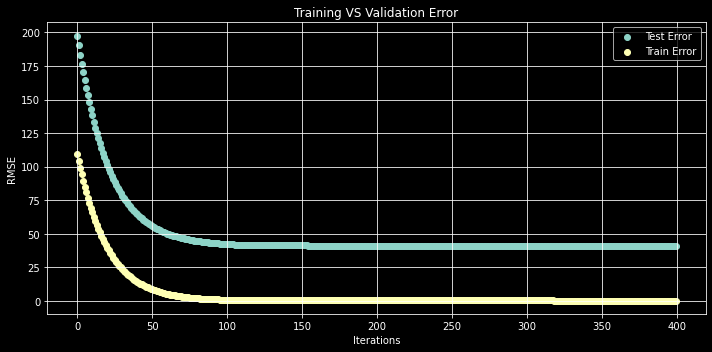

In [47]:
eval_result = best['model'].evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(training_rounds, eval_result['validation_0']['rmse'], label='Test Error')
plt.scatter(training_rounds, eval_result['validation_1']['rmse'], label='Train Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

# Two Hyperparameters

In [48]:
n_estimators =  [100, 200, 300, 400]
learning_rate =  [0.001, 0.005, 0.01, 0.05]

In [49]:
best = {'rmse': 200,
        'n_estimator': None,
        'learning_rate': None,
        'model': None}

for n_est in n_estimators:
    for lr in learning_rate:
        regressor = xgb.XGBRegressor(n_estimators=n_est, base_score=0.7, colsample_bytree=1, learning_rate=lr)
        xgbModel = regressor.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
        rmse = regressor.evals_result()['validation_0']['rmse'][-1]
        if rmse < best['rmse']:
            best['rmse'] = rmse
            best['n_estimator'] = n_est
            best['learning_rate'] = lr
            best['model'] = regressor

[0]	validation_0-rmse:205.09616	validation_1-rmse:115.42066
[1]	validation_0-rmse:204.94362	validation_1-rmse:115.30574
[2]	validation_0-rmse:204.79123	validation_1-rmse:115.19094
[3]	validation_0-rmse:204.63899	validation_1-rmse:115.07626
[4]	validation_0-rmse:204.48689	validation_1-rmse:114.96171
[5]	validation_0-rmse:204.33493	validation_1-rmse:114.84726
[6]	validation_0-rmse:204.18315	validation_1-rmse:114.73292
[7]	validation_0-rmse:204.03151	validation_1-rmse:114.61869
[8]	validation_0-rmse:203.88003	validation_1-rmse:114.50459
[9]	validation_0-rmse:203.72871	validation_1-rmse:114.39059
[10]	validation_0-rmse:203.57753	validation_1-rmse:114.27671
[11]	validation_0-rmse:203.42651	validation_1-rmse:114.16293
[12]	validation_0-rmse:203.27560	validation_1-rmse:114.04929
[13]	validation_0-rmse:203.12491	validation_1-rmse:113.93576
[14]	validation_0-rmse:202.97433	validation_1-rmse:113.82231
[15]	validation_0-rmse:202.82391	validation_1-rmse:113.70900
[16]	validation_0-rmse:202.67364	v

[35]	validation_0-rmse:179.97856	validation_1-rmse:96.53948
[36]	validation_0-rmse:179.34428	validation_1-rmse:96.05907
[37]	validation_0-rmse:178.71448	validation_1-rmse:95.58106
[38]	validation_0-rmse:178.07445	validation_1-rmse:95.10532
[39]	validation_0-rmse:177.45091	validation_1-rmse:94.63206
[40]	validation_0-rmse:176.81753	validation_1-rmse:94.16112
[41]	validation_0-rmse:176.18707	validation_1-rmse:93.69247
[42]	validation_0-rmse:175.57281	validation_1-rmse:93.22624
[43]	validation_0-rmse:174.94859	validation_1-rmse:92.76228
[44]	validation_0-rmse:174.34052	validation_1-rmse:92.30070
[45]	validation_0-rmse:173.71942	validation_1-rmse:91.84131
[46]	validation_0-rmse:173.11813	validation_1-rmse:91.38433
[47]	validation_0-rmse:172.51442	validation_1-rmse:90.92961
[48]	validation_0-rmse:171.90253	validation_1-rmse:90.47707
[49]	validation_0-rmse:171.31091	validation_1-rmse:90.02689
[50]	validation_0-rmse:170.70721	validation_1-rmse:89.57885
[51]	validation_0-rmse:170.11896	validat

[72]	validation_0-rmse:123.83331	validation_1-rmse:55.67095
[73]	validation_0-rmse:123.02811	validation_1-rmse:55.11705
[74]	validation_0-rmse:122.27925	validation_1-rmse:54.56864
[75]	validation_0-rmse:121.48729	validation_1-rmse:54.02579
[76]	validation_0-rmse:120.75777	validation_1-rmse:53.48831
[77]	validation_0-rmse:120.00148	validation_1-rmse:52.95613
[78]	validation_0-rmse:119.28224	validation_1-rmse:52.42925
[79]	validation_0-rmse:118.52052	validation_1-rmse:51.90773
[80]	validation_0-rmse:117.76887	validation_1-rmse:51.39128
[81]	validation_0-rmse:117.07359	validation_1-rmse:50.88004
[82]	validation_0-rmse:116.33498	validation_1-rmse:50.37387
[83]	validation_0-rmse:115.64801	validation_1-rmse:49.87269
[84]	validation_0-rmse:114.92300	validation_1-rmse:49.37662
[85]	validation_0-rmse:114.22945	validation_1-rmse:48.88536
[86]	validation_0-rmse:113.56762	validation_1-rmse:48.39908
[87]	validation_0-rmse:112.90749	validation_1-rmse:47.91755
[88]	validation_0-rmse:112.21175	validat

[11]	validation_0-rmse:203.42651	validation_1-rmse:114.16293
[12]	validation_0-rmse:203.27562	validation_1-rmse:114.04929
[13]	validation_0-rmse:203.12491	validation_1-rmse:113.93575
[14]	validation_0-rmse:202.97433	validation_1-rmse:113.82231
[15]	validation_0-rmse:202.82391	validation_1-rmse:113.70900
[16]	validation_0-rmse:202.67364	validation_1-rmse:113.59582
[17]	validation_0-rmse:202.52353	validation_1-rmse:113.48271
[18]	validation_0-rmse:202.37354	validation_1-rmse:113.36975
[19]	validation_0-rmse:202.22376	validation_1-rmse:113.25690
[20]	validation_0-rmse:202.07410	validation_1-rmse:113.14416
[21]	validation_0-rmse:201.92459	validation_1-rmse:113.03151
[22]	validation_0-rmse:201.77519	validation_1-rmse:112.91898
[23]	validation_0-rmse:201.62598	validation_1-rmse:112.80655
[24]	validation_0-rmse:201.47693	validation_1-rmse:112.69426
[25]	validation_0-rmse:201.32799	validation_1-rmse:112.58208
[26]	validation_0-rmse:201.17925	validation_1-rmse:112.46999
[27]	validation_0-rmse:2

[145]	validation_0-rmse:184.46205	validation_1-rmse:99.89996
[146]	validation_0-rmse:184.32996	validation_1-rmse:99.80053
[147]	validation_0-rmse:184.19875	validation_1-rmse:99.70120
[148]	validation_0-rmse:184.06529	validation_1-rmse:99.60194
[149]	validation_0-rmse:183.93436	validation_1-rmse:99.50280
[150]	validation_0-rmse:183.80115	validation_1-rmse:99.40376
[151]	validation_0-rmse:183.67050	validation_1-rmse:99.30482
[152]	validation_0-rmse:183.53764	validation_1-rmse:99.20597
[153]	validation_0-rmse:183.40678	validation_1-rmse:99.10725
[154]	validation_0-rmse:183.27411	validation_1-rmse:99.00858
[155]	validation_0-rmse:183.14325	validation_1-rmse:98.91004
[156]	validation_0-rmse:183.01083	validation_1-rmse:98.81158
[157]	validation_0-rmse:182.88100	validation_1-rmse:98.71323
[158]	validation_0-rmse:182.75120	validation_1-rmse:98.61499
[159]	validation_0-rmse:182.61920	validation_1-rmse:98.51683
[160]	validation_0-rmse:182.48967	validation_1-rmse:98.41877
[161]	validation_0-rmse:

[81]	validation_0-rmse:153.16353	validation_1-rmse:76.74448
[82]	validation_0-rmse:152.61906	validation_1-rmse:76.36269
[83]	validation_0-rmse:152.10455	validation_1-rmse:75.98270
[84]	validation_0-rmse:151.57700	validation_1-rmse:75.60465
[85]	validation_0-rmse:151.07130	validation_1-rmse:75.22850
[86]	validation_0-rmse:150.54756	validation_1-rmse:74.85421
[87]	validation_0-rmse:150.04329	validation_1-rmse:74.48172
[88]	validation_0-rmse:149.51285	validation_1-rmse:74.11115
[89]	validation_0-rmse:149.01440	validation_1-rmse:73.74242
[90]	validation_0-rmse:148.48743	validation_1-rmse:73.37553
[91]	validation_0-rmse:148.00166	validation_1-rmse:73.01051
[92]	validation_0-rmse:147.50986	validation_1-rmse:72.64720
[93]	validation_0-rmse:146.99042	validation_1-rmse:72.28577
[94]	validation_0-rmse:146.50352	validation_1-rmse:71.92609
[95]	validation_0-rmse:146.02544	validation_1-rmse:71.56827
[96]	validation_0-rmse:145.51346	validation_1-rmse:71.21220
[97]	validation_0-rmse:145.03383	validat

[16]	validation_0-rmse:181.21704	validation_1-rmse:97.46603
[17]	validation_0-rmse:179.91980	validation_1-rmse:96.49593
[18]	validation_0-rmse:178.65448	validation_1-rmse:95.53554
[19]	validation_0-rmse:177.37506	validation_1-rmse:94.58459
[20]	validation_0-rmse:176.13202	validation_1-rmse:93.64326
[21]	validation_0-rmse:174.87677	validation_1-rmse:92.71112
[22]	validation_0-rmse:173.66135	validation_1-rmse:91.78847
[23]	validation_0-rmse:172.42609	validation_1-rmse:90.87480
[24]	validation_0-rmse:171.23633	validation_1-rmse:89.97047
[25]	validation_0-rmse:170.03206	validation_1-rmse:89.07503
[26]	validation_0-rmse:168.83336	validation_1-rmse:88.18840
[27]	validation_0-rmse:167.61053	validation_1-rmse:87.31084
[28]	validation_0-rmse:166.44159	validation_1-rmse:86.44187
[29]	validation_0-rmse:165.24281	validation_1-rmse:85.58173
[30]	validation_0-rmse:164.08893	validation_1-rmse:84.72989
[31]	validation_0-rmse:162.91383	validation_1-rmse:83.88676
[32]	validation_0-rmse:161.79158	validat

[153]	validation_0-rmse:79.82961	validation_1-rmse:24.77590
[154]	validation_0-rmse:79.48649	validation_1-rmse:24.52963
[155]	validation_0-rmse:79.12316	validation_1-rmse:24.28580
[156]	validation_0-rmse:78.78700	validation_1-rmse:24.04440
[157]	validation_0-rmse:78.42701	validation_1-rmse:23.80544
[158]	validation_0-rmse:78.07739	validation_1-rmse:23.56879
[159]	validation_0-rmse:77.75307	validation_1-rmse:23.33456
[160]	validation_0-rmse:77.40887	validation_1-rmse:23.10261
[161]	validation_0-rmse:77.06126	validation_1-rmse:22.87304
[162]	validation_0-rmse:76.71879	validation_1-rmse:22.64573
[163]	validation_0-rmse:76.40578	validation_1-rmse:22.42068
[164]	validation_0-rmse:76.06843	validation_1-rmse:22.19790
[165]	validation_0-rmse:75.73978	validation_1-rmse:21.97727
[166]	validation_0-rmse:75.43622	validation_1-rmse:21.75888
[167]	validation_0-rmse:75.10880	validation_1-rmse:21.54268
[168]	validation_0-rmse:74.81194	validation_1-rmse:21.32862
[169]	validation_0-rmse:74.49252	validat

[92]	validation_0-rmse:42.96787	validation_1-rmse:1.12778
[93]	validation_0-rmse:42.86788	validation_1-rmse:1.08214
[94]	validation_0-rmse:42.77457	validation_1-rmse:1.03917
[95]	validation_0-rmse:42.68379	validation_1-rmse:0.99847
[96]	validation_0-rmse:42.59735	validation_1-rmse:0.96013
[97]	validation_0-rmse:42.51500	validation_1-rmse:0.92417
[98]	validation_0-rmse:42.43656	validation_1-rmse:0.89030
[99]	validation_0-rmse:42.36335	validation_1-rmse:0.85840
[100]	validation_0-rmse:42.29434	validation_1-rmse:0.82810
[101]	validation_0-rmse:42.22640	validation_1-rmse:0.80004
[102]	validation_0-rmse:42.16099	validation_1-rmse:0.77368
[103]	validation_0-rmse:42.10959	validation_1-rmse:0.74891
[104]	validation_0-rmse:42.05642	validation_1-rmse:0.72547
[105]	validation_0-rmse:42.00568	validation_1-rmse:0.70389
[106]	validation_0-rmse:41.96108	validation_1-rmse:0.68326
[107]	validation_0-rmse:41.91472	validation_1-rmse:0.66415
[108]	validation_0-rmse:41.86998	validation_1-rmse:0.64622
[109]

[31]	validation_0-rmse:200.43759	validation_1-rmse:111.91128
[32]	validation_0-rmse:200.28961	validation_1-rmse:111.79988
[33]	validation_0-rmse:200.14191	validation_1-rmse:111.68859
[34]	validation_0-rmse:199.99432	validation_1-rmse:111.57740
[35]	validation_0-rmse:199.84677	validation_1-rmse:111.46634
[36]	validation_0-rmse:199.69943	validation_1-rmse:111.35536
[37]	validation_0-rmse:199.55229	validation_1-rmse:111.24451
[38]	validation_0-rmse:199.40512	validation_1-rmse:111.13376
[39]	validation_0-rmse:199.25830	validation_1-rmse:111.02312
[40]	validation_0-rmse:199.11142	validation_1-rmse:110.91260
[41]	validation_0-rmse:198.96490	validation_1-rmse:110.80219
[42]	validation_0-rmse:198.81838	validation_1-rmse:110.69189
[43]	validation_0-rmse:198.67197	validation_1-rmse:110.58168
[44]	validation_0-rmse:198.52585	validation_1-rmse:110.47160
[45]	validation_0-rmse:198.37975	validation_1-rmse:110.36162
[46]	validation_0-rmse:198.23392	validation_1-rmse:110.25178
[47]	validation_0-rmse:1

[165]	validation_0-rmse:181.83872	validation_1-rmse:97.92994
[166]	validation_0-rmse:181.70761	validation_1-rmse:97.83247
[167]	validation_0-rmse:181.57899	validation_1-rmse:97.73508
[168]	validation_0-rmse:181.44818	validation_1-rmse:97.63781
[169]	validation_0-rmse:181.31746	validation_1-rmse:97.54060
[170]	validation_0-rmse:181.18929	validation_1-rmse:97.44353
[171]	validation_0-rmse:181.06050	validation_1-rmse:97.34656
[172]	validation_0-rmse:180.93019	validation_1-rmse:97.24966
[173]	validation_0-rmse:180.80235	validation_1-rmse:97.15286
[174]	validation_0-rmse:180.67232	validation_1-rmse:97.05616
[175]	validation_0-rmse:180.54478	validation_1-rmse:96.95956
[176]	validation_0-rmse:180.41739	validation_1-rmse:96.86306
[177]	validation_0-rmse:180.28772	validation_1-rmse:96.76665
[178]	validation_0-rmse:180.15994	validation_1-rmse:96.67034
[179]	validation_0-rmse:180.03053	validation_1-rmse:96.57410
[180]	validation_0-rmse:179.90389	validation_1-rmse:96.47800
[181]	validation_0-rmse:

[0]	validation_0-rmse:204.48535	validation_1-rmse:114.96055
[1]	validation_0-rmse:203.72569	validation_1-rmse:114.38831
[2]	validation_0-rmse:202.96983	validation_1-rmse:113.81892
[3]	validation_0-rmse:202.21779	validation_1-rmse:113.25236
[4]	validation_0-rmse:201.46948	validation_1-rmse:112.68864
[5]	validation_0-rmse:200.72496	validation_1-rmse:112.12772
[6]	validation_0-rmse:199.98387	validation_1-rmse:111.56959
[7]	validation_0-rmse:199.24683	validation_1-rmse:111.01429
[8]	validation_0-rmse:198.51256	validation_1-rmse:110.46169
[9]	validation_0-rmse:197.78288	validation_1-rmse:109.91190
[10]	validation_0-rmse:197.05595	validation_1-rmse:109.36479
[11]	validation_0-rmse:196.33420	validation_1-rmse:108.82046
[12]	validation_0-rmse:195.61606	validation_1-rmse:108.27882
[13]	validation_0-rmse:194.90002	validation_1-rmse:107.73987
[14]	validation_0-rmse:194.18909	validation_1-rmse:107.20359
[15]	validation_0-rmse:193.47540	validation_1-rmse:106.67000
[16]	validation_0-rmse:192.77155	v

[136]	validation_0-rmse:127.52335	validation_1-rmse:58.33310
[137]	validation_0-rmse:127.11603	validation_1-rmse:58.04289
[138]	validation_0-rmse:126.72253	validation_1-rmse:57.75412
[139]	validation_0-rmse:126.30454	validation_1-rmse:57.46685
[140]	validation_0-rmse:125.91634	validation_1-rmse:57.18098
[141]	validation_0-rmse:125.50816	validation_1-rmse:56.89651
[142]	validation_0-rmse:125.12537	validation_1-rmse:56.61349
[143]	validation_0-rmse:124.72926	validation_1-rmse:56.33183
[144]	validation_0-rmse:124.34703	validation_1-rmse:56.05159
[145]	validation_0-rmse:123.94141	validation_1-rmse:55.77278
[146]	validation_0-rmse:123.56627	validation_1-rmse:55.49537
[147]	validation_0-rmse:123.16500	validation_1-rmse:55.21929
[148]	validation_0-rmse:122.79034	validation_1-rmse:54.94457
[149]	validation_0-rmse:122.39176	validation_1-rmse:54.67130
[150]	validation_0-rmse:122.00126	validation_1-rmse:54.39932
[151]	validation_0-rmse:121.63306	validation_1-rmse:54.12871
[152]	validation_0-rmse:

[272]	validation_0-rmse:86.81162	validation_1-rmse:29.61055
[273]	validation_0-rmse:86.60686	validation_1-rmse:29.46334
[274]	validation_0-rmse:86.38895	validation_1-rmse:29.31688
[275]	validation_0-rmse:86.18662	validation_1-rmse:29.17114
[276]	validation_0-rmse:85.97250	validation_1-rmse:29.02611
[277]	validation_0-rmse:85.75667	validation_1-rmse:28.88184
[278]	validation_0-rmse:85.55637	validation_1-rmse:28.73825
[279]	validation_0-rmse:85.34433	validation_1-rmse:28.59539
[280]	validation_0-rmse:85.14707	validation_1-rmse:28.45324
[281]	validation_0-rmse:84.93877	validation_1-rmse:28.31177
[282]	validation_0-rmse:84.74249	validation_1-rmse:28.17102
[283]	validation_0-rmse:84.53406	validation_1-rmse:28.03101
[284]	validation_0-rmse:84.32473	validation_1-rmse:27.89169
[285]	validation_0-rmse:84.13144	validation_1-rmse:27.75303
[286]	validation_0-rmse:83.92664	validation_1-rmse:27.61507
[287]	validation_0-rmse:83.73596	validation_1-rmse:27.47780
[288]	validation_0-rmse:83.53267	validat

[109]	validation_0-rmse:99.50480	validation_1-rmse:38.45766
[110]	validation_0-rmse:98.97669	validation_1-rmse:38.07515
[111]	validation_0-rmse:98.42052	validation_1-rmse:37.69640
[112]	validation_0-rmse:97.86556	validation_1-rmse:37.32156
[113]	validation_0-rmse:97.35053	validation_1-rmse:36.95034
[114]	validation_0-rmse:96.81012	validation_1-rmse:36.58282
[115]	validation_0-rmse:96.31304	validation_1-rmse:36.21904
[116]	validation_0-rmse:95.78322	validation_1-rmse:35.85884
[117]	validation_0-rmse:95.28860	validation_1-rmse:35.50220
[118]	validation_0-rmse:94.76545	validation_1-rmse:35.14919
[119]	validation_0-rmse:94.28084	validation_1-rmse:34.79960
[120]	validation_0-rmse:93.80685	validation_1-rmse:34.45357
[121]	validation_0-rmse:93.30245	validation_1-rmse:34.11089
[122]	validation_0-rmse:92.79953	validation_1-rmse:33.77170
[123]	validation_0-rmse:92.33227	validation_1-rmse:33.43583
[124]	validation_0-rmse:91.87907	validation_1-rmse:33.10340
[125]	validation_0-rmse:91.39425	validat

[246]	validation_0-rmse:57.58544	validation_1-rmse:9.79718
[247]	validation_0-rmse:57.43195	validation_1-rmse:9.70012
[248]	validation_0-rmse:57.29107	validation_1-rmse:9.60403
[249]	validation_0-rmse:57.13628	validation_1-rmse:9.50892
[250]	validation_0-rmse:56.97976	validation_1-rmse:9.41476
[251]	validation_0-rmse:56.84174	validation_1-rmse:9.32152
[252]	validation_0-rmse:56.69311	validation_1-rmse:9.22922
[253]	validation_0-rmse:56.54107	validation_1-rmse:9.13785
[254]	validation_0-rmse:56.40688	validation_1-rmse:9.04736
[255]	validation_0-rmse:56.26260	validation_1-rmse:8.95778
[256]	validation_0-rmse:56.11491	validation_1-rmse:8.86912
[257]	validation_0-rmse:55.98579	validation_1-rmse:8.78133
[258]	validation_0-rmse:55.85693	validation_1-rmse:8.69441
[259]	validation_0-rmse:55.71333	validation_1-rmse:8.60838
[260]	validation_0-rmse:55.56980	validation_1-rmse:8.52321
[261]	validation_0-rmse:55.44428	validation_1-rmse:8.43886
[262]	validation_0-rmse:55.30792	validation_1-rmse:8.355

[86]	validation_0-rmse:43.67960	validation_1-rmse:1.46385
[87]	validation_0-rmse:43.54561	validation_1-rmse:1.39959
[88]	validation_0-rmse:43.41803	validation_1-rmse:1.33896
[89]	validation_0-rmse:43.29653	validation_1-rmse:1.28144
[90]	validation_0-rmse:43.18086	validation_1-rmse:1.22709
[91]	validation_0-rmse:43.07286	validation_1-rmse:1.17598
[92]	validation_0-rmse:42.96787	validation_1-rmse:1.12778
[93]	validation_0-rmse:42.86788	validation_1-rmse:1.08214
[94]	validation_0-rmse:42.77457	validation_1-rmse:1.03917
[95]	validation_0-rmse:42.68380	validation_1-rmse:0.99847
[96]	validation_0-rmse:42.59735	validation_1-rmse:0.96013
[97]	validation_0-rmse:42.51500	validation_1-rmse:0.92417
[98]	validation_0-rmse:42.43655	validation_1-rmse:0.89030
[99]	validation_0-rmse:42.36335	validation_1-rmse:0.85840
[100]	validation_0-rmse:42.29434	validation_1-rmse:0.82810
[101]	validation_0-rmse:42.22640	validation_1-rmse:0.80004
[102]	validation_0-rmse:42.16099	validation_1-rmse:0.77368
[103]	valid

[226]	validation_0-rmse:41.15197	validation_1-rmse:0.33765
[227]	validation_0-rmse:41.15149	validation_1-rmse:0.33692
[228]	validation_0-rmse:41.15120	validation_1-rmse:0.33605
[229]	validation_0-rmse:41.15112	validation_1-rmse:0.33568
[230]	validation_0-rmse:41.14650	validation_1-rmse:0.33518
[231]	validation_0-rmse:41.14597	validation_1-rmse:0.33497
[232]	validation_0-rmse:41.14131	validation_1-rmse:0.33400
[233]	validation_0-rmse:41.14126	validation_1-rmse:0.33361
[234]	validation_0-rmse:41.14129	validation_1-rmse:0.33255
[235]	validation_0-rmse:41.14105	validation_1-rmse:0.33200
[236]	validation_0-rmse:41.14097	validation_1-rmse:0.33177
[237]	validation_0-rmse:41.14114	validation_1-rmse:0.33115
[238]	validation_0-rmse:41.14109	validation_1-rmse:0.33083
[239]	validation_0-rmse:41.13681	validation_1-rmse:0.33019
[240]	validation_0-rmse:41.13677	validation_1-rmse:0.32879
[241]	validation_0-rmse:41.13636	validation_1-rmse:0.32801
[242]	validation_0-rmse:41.13625	validation_1-rmse:0.327

[63]	validation_0-rmse:195.77725	validation_1-rmse:108.40072
[64]	validation_0-rmse:195.63388	validation_1-rmse:108.29280
[65]	validation_0-rmse:195.49094	validation_1-rmse:108.18500
[66]	validation_0-rmse:195.34786	validation_1-rmse:108.07732
[67]	validation_0-rmse:195.20522	validation_1-rmse:107.96972
[68]	validation_0-rmse:195.06242	validation_1-rmse:107.86224
[69]	validation_0-rmse:194.92006	validation_1-rmse:107.75487
[70]	validation_0-rmse:194.77756	validation_1-rmse:107.64759
[71]	validation_0-rmse:194.63550	validation_1-rmse:107.54043
[72]	validation_0-rmse:194.49358	validation_1-rmse:107.43339
[73]	validation_0-rmse:194.35101	validation_1-rmse:107.32644
[74]	validation_0-rmse:194.20937	validation_1-rmse:107.21959
[75]	validation_0-rmse:194.06661	validation_1-rmse:107.11285
[76]	validation_0-rmse:193.92526	validation_1-rmse:107.00622
[77]	validation_0-rmse:193.78381	validation_1-rmse:106.89972
[78]	validation_0-rmse:193.64145	validation_1-rmse:106.79330
[79]	validation_0-rmse:1

[197]	validation_0-rmse:177.74814	validation_1-rmse:94.85847
[198]	validation_0-rmse:177.62109	validation_1-rmse:94.76405
[199]	validation_0-rmse:177.49654	validation_1-rmse:94.66972
[200]	validation_0-rmse:177.36980	validation_1-rmse:94.57551
[201]	validation_0-rmse:177.24580	validation_1-rmse:94.48139
[202]	validation_0-rmse:177.11928	validation_1-rmse:94.38734
[203]	validation_0-rmse:176.99551	validation_1-rmse:94.29340
[204]	validation_0-rmse:176.86923	validation_1-rmse:94.19955
[205]	validation_0-rmse:176.74573	validation_1-rmse:94.10580
[206]	validation_0-rmse:176.62143	validation_1-rmse:94.01214
[207]	validation_0-rmse:176.49553	validation_1-rmse:93.91856
[208]	validation_0-rmse:176.37238	validation_1-rmse:93.82510
[209]	validation_0-rmse:176.24674	validation_1-rmse:93.73171
[210]	validation_0-rmse:176.12384	validation_1-rmse:93.63841
[211]	validation_0-rmse:175.99847	validation_1-rmse:93.54522
[212]	validation_0-rmse:175.87585	validation_1-rmse:93.45212
[213]	validation_0-rmse:

[332]	validation_0-rmse:161.63725	validation_1-rmse:82.92715
[333]	validation_0-rmse:161.52547	validation_1-rmse:82.84463
[334]	validation_0-rmse:161.41054	validation_1-rmse:82.76220
[335]	validation_0-rmse:161.29542	validation_1-rmse:82.67983
[336]	validation_0-rmse:161.18396	validation_1-rmse:82.59753
[337]	validation_0-rmse:161.06905	validation_1-rmse:82.51535
[338]	validation_0-rmse:160.95862	validation_1-rmse:82.43323
[339]	validation_0-rmse:160.84425	validation_1-rmse:82.35120
[340]	validation_0-rmse:160.73323	validation_1-rmse:82.26923
[341]	validation_0-rmse:160.61879	validation_1-rmse:82.18737
[342]	validation_0-rmse:160.50885	validation_1-rmse:82.10558
[343]	validation_0-rmse:160.39816	validation_1-rmse:82.02386
[344]	validation_0-rmse:160.28407	validation_1-rmse:81.94223
[345]	validation_0-rmse:160.17366	validation_1-rmse:81.86068
[346]	validation_0-rmse:160.06570	validation_1-rmse:81.77923
[347]	validation_0-rmse:159.95548	validation_1-rmse:81.69783
[348]	validation_0-rmse:

[68]	validation_0-rmse:160.23343	validation_1-rmse:81.88596
[69]	validation_0-rmse:159.68596	validation_1-rmse:81.47851
[70]	validation_0-rmse:159.11908	validation_1-rmse:81.07311
[71]	validation_0-rmse:158.57263	validation_1-rmse:80.66963
[72]	validation_0-rmse:158.01134	validation_1-rmse:80.26827
[73]	validation_0-rmse:157.47148	validation_1-rmse:79.86887
[74]	validation_0-rmse:156.91573	validation_1-rmse:79.47148
[75]	validation_0-rmse:156.38016	validation_1-rmse:79.07600
[76]	validation_0-rmse:155.81792	validation_1-rmse:78.68263
[77]	validation_0-rmse:155.28769	validation_1-rmse:78.29108
[78]	validation_0-rmse:154.74281	validation_1-rmse:77.90153
[79]	validation_0-rmse:154.22270	validation_1-rmse:77.51395
[80]	validation_0-rmse:153.70039	validation_1-rmse:77.12822
[81]	validation_0-rmse:153.16353	validation_1-rmse:76.74448
[82]	validation_0-rmse:152.61905	validation_1-rmse:76.36269
[83]	validation_0-rmse:152.10455	validation_1-rmse:75.98270
[84]	validation_0-rmse:151.57700	validat

[203]	validation_0-rmse:104.21678	validation_1-rmse:41.76585
[204]	validation_0-rmse:103.93130	validation_1-rmse:41.55812
[205]	validation_0-rmse:103.62707	validation_1-rmse:41.35148
[206]	validation_0-rmse:103.32539	validation_1-rmse:41.14581
[207]	validation_0-rmse:103.04532	validation_1-rmse:40.94120
[208]	validation_0-rmse:102.74622	validation_1-rmse:40.73759
[209]	validation_0-rmse:102.46784	validation_1-rmse:40.53498
[210]	validation_0-rmse:102.17104	validation_1-rmse:40.33343
[211]	validation_0-rmse:101.87674	validation_1-rmse:40.13282
[212]	validation_0-rmse:101.60474	validation_1-rmse:39.93326
[213]	validation_0-rmse:101.33041	validation_1-rmse:39.73465
[214]	validation_0-rmse:101.04000	validation_1-rmse:39.53703
[215]	validation_0-rmse:100.77125	validation_1-rmse:39.34043
[216]	validation_0-rmse:100.48305	validation_1-rmse:39.14482
[217]	validation_0-rmse:100.21418	validation_1-rmse:38.95014
[218]	validation_0-rmse:99.92944	validation_1-rmse:38.75645
[219]	validation_0-rmse:9

[340]	validation_0-rmse:74.44890	validation_1-rmse:21.10127
[341]	validation_0-rmse:74.29022	validation_1-rmse:20.99644
[342]	validation_0-rmse:74.14499	validation_1-rmse:20.89213
[343]	validation_0-rmse:73.98865	validation_1-rmse:20.78833
[344]	validation_0-rmse:73.84448	validation_1-rmse:20.68505
[345]	validation_0-rmse:73.68890	validation_1-rmse:20.58230
[346]	validation_0-rmse:73.53790	validation_1-rmse:20.48002
[347]	validation_0-rmse:73.38363	validation_1-rmse:20.37829
[348]	validation_0-rmse:73.23286	validation_1-rmse:20.27704
[349]	validation_0-rmse:73.09232	validation_1-rmse:20.17631
[350]	validation_0-rmse:72.94057	validation_1-rmse:20.07608
[351]	validation_0-rmse:72.80059	validation_1-rmse:19.97634
[352]	validation_0-rmse:72.65009	validation_1-rmse:19.87712
[353]	validation_0-rmse:72.50133	validation_1-rmse:19.77838
[354]	validation_0-rmse:72.36350	validation_1-rmse:19.68012
[355]	validation_0-rmse:72.21791	validation_1-rmse:19.58234
[356]	validation_0-rmse:72.08188	validat

[77]	validation_0-rmse:120.00148	validation_1-rmse:52.95613
[78]	validation_0-rmse:119.28224	validation_1-rmse:52.42925
[79]	validation_0-rmse:118.52052	validation_1-rmse:51.90773
[80]	validation_0-rmse:117.76887	validation_1-rmse:51.39128
[81]	validation_0-rmse:117.07359	validation_1-rmse:50.88004
[82]	validation_0-rmse:116.33498	validation_1-rmse:50.37387
[83]	validation_0-rmse:115.64801	validation_1-rmse:49.87268
[84]	validation_0-rmse:114.92300	validation_1-rmse:49.37662
[85]	validation_0-rmse:114.22945	validation_1-rmse:48.88536
[86]	validation_0-rmse:113.56762	validation_1-rmse:48.39908
[87]	validation_0-rmse:112.90749	validation_1-rmse:47.91755
[88]	validation_0-rmse:112.21175	validation_1-rmse:47.44083
[89]	validation_0-rmse:111.57648	validation_1-rmse:46.96899
[90]	validation_0-rmse:110.93600	validation_1-rmse:46.50174
[91]	validation_0-rmse:110.25865	validation_1-rmse:46.03911
[92]	validation_0-rmse:109.58740	validation_1-rmse:45.58116
[93]	validation_0-rmse:108.96600	validat

[214]	validation_0-rmse:63.21489	validation_1-rmse:13.47663
[215]	validation_0-rmse:63.02399	validation_1-rmse:13.34290
[216]	validation_0-rmse:62.81576	validation_1-rmse:13.21052
[217]	validation_0-rmse:62.62791	validation_1-rmse:13.07944
[218]	validation_0-rmse:62.44201	validation_1-rmse:12.94967
[219]	validation_0-rmse:62.23663	validation_1-rmse:12.82122
[220]	validation_0-rmse:62.05341	validation_1-rmse:12.69401
[221]	validation_0-rmse:61.85200	validation_1-rmse:12.56810
[222]	validation_0-rmse:61.67164	validation_1-rmse:12.44342
[223]	validation_0-rmse:61.47710	validation_1-rmse:12.31999
[224]	validation_0-rmse:61.30039	validation_1-rmse:12.19778
[225]	validation_0-rmse:61.10666	validation_1-rmse:12.07681
[226]	validation_0-rmse:60.92171	validation_1-rmse:11.95702
[227]	validation_0-rmse:60.73182	validation_1-rmse:11.83846
[228]	validation_0-rmse:60.56186	validation_1-rmse:11.72105
[229]	validation_0-rmse:60.37564	validation_1-rmse:11.60482
[230]	validation_0-rmse:60.19132	validat

[353]	validation_0-rmse:47.17635	validation_1-rmse:3.40347
[354]	validation_0-rmse:47.11691	validation_1-rmse:3.37047
[355]	validation_0-rmse:47.05805	validation_1-rmse:3.33780
[356]	validation_0-rmse:47.00420	validation_1-rmse:3.30546
[357]	validation_0-rmse:46.94645	validation_1-rmse:3.27346
[358]	validation_0-rmse:46.89366	validation_1-rmse:3.24178
[359]	validation_0-rmse:46.84241	validation_1-rmse:3.21043
[360]	validation_0-rmse:46.78624	validation_1-rmse:3.17939
[361]	validation_0-rmse:46.73624	validation_1-rmse:3.14866
[362]	validation_0-rmse:46.68112	validation_1-rmse:3.11824
[363]	validation_0-rmse:46.63183	validation_1-rmse:3.08812
[364]	validation_0-rmse:46.58203	validation_1-rmse:3.05833
[365]	validation_0-rmse:46.52844	validation_1-rmse:3.02883
[366]	validation_0-rmse:46.47961	validation_1-rmse:2.99963
[367]	validation_0-rmse:46.43221	validation_1-rmse:2.97074
[368]	validation_0-rmse:46.38010	validation_1-rmse:2.94213
[369]	validation_0-rmse:46.33242	validation_1-rmse:2.913

[93]	validation_0-rmse:42.86788	validation_1-rmse:1.08214
[94]	validation_0-rmse:42.77457	validation_1-rmse:1.03917
[95]	validation_0-rmse:42.68379	validation_1-rmse:0.99847
[96]	validation_0-rmse:42.59734	validation_1-rmse:0.96013
[97]	validation_0-rmse:42.51500	validation_1-rmse:0.92417
[98]	validation_0-rmse:42.43656	validation_1-rmse:0.89030
[99]	validation_0-rmse:42.36335	validation_1-rmse:0.85840
[100]	validation_0-rmse:42.29434	validation_1-rmse:0.82810
[101]	validation_0-rmse:42.22640	validation_1-rmse:0.80004
[102]	validation_0-rmse:42.16099	validation_1-rmse:0.77368
[103]	validation_0-rmse:42.10959	validation_1-rmse:0.74891
[104]	validation_0-rmse:42.05642	validation_1-rmse:0.72547
[105]	validation_0-rmse:42.00568	validation_1-rmse:0.70389
[106]	validation_0-rmse:41.96108	validation_1-rmse:0.68326
[107]	validation_0-rmse:41.91472	validation_1-rmse:0.66415
[108]	validation_0-rmse:41.86998	validation_1-rmse:0.64622
[109]	validation_0-rmse:41.81814	validation_1-rmse:0.62948
[110

[232]	validation_0-rmse:41.14131	validation_1-rmse:0.33400
[233]	validation_0-rmse:41.14126	validation_1-rmse:0.33361
[234]	validation_0-rmse:41.14129	validation_1-rmse:0.33255
[235]	validation_0-rmse:41.14105	validation_1-rmse:0.33200
[236]	validation_0-rmse:41.14097	validation_1-rmse:0.33177
[237]	validation_0-rmse:41.14114	validation_1-rmse:0.33115
[238]	validation_0-rmse:41.14109	validation_1-rmse:0.33083
[239]	validation_0-rmse:41.13681	validation_1-rmse:0.33019
[240]	validation_0-rmse:41.13677	validation_1-rmse:0.32879
[241]	validation_0-rmse:41.13636	validation_1-rmse:0.32801
[242]	validation_0-rmse:41.13625	validation_1-rmse:0.32766
[243]	validation_0-rmse:41.13589	validation_1-rmse:0.32715
[244]	validation_0-rmse:41.13591	validation_1-rmse:0.32603
[245]	validation_0-rmse:41.13543	validation_1-rmse:0.32585
[246]	validation_0-rmse:41.13113	validation_1-rmse:0.32563
[247]	validation_0-rmse:41.13091	validation_1-rmse:0.32482
[248]	validation_0-rmse:41.13076	validation_1-rmse:0.323

[371]	validation_0-rmse:41.08314	validation_1-rmse:0.25353
[372]	validation_0-rmse:41.08303	validation_1-rmse:0.25328
[373]	validation_0-rmse:41.08306	validation_1-rmse:0.25300
[374]	validation_0-rmse:41.08358	validation_1-rmse:0.25284
[375]	validation_0-rmse:41.08365	validation_1-rmse:0.25250
[376]	validation_0-rmse:41.08311	validation_1-rmse:0.25194
[377]	validation_0-rmse:41.08323	validation_1-rmse:0.25132
[378]	validation_0-rmse:41.08308	validation_1-rmse:0.25111
[379]	validation_0-rmse:41.07761	validation_1-rmse:0.25050
[380]	validation_0-rmse:41.07906	validation_1-rmse:0.24993
[381]	validation_0-rmse:41.07951	validation_1-rmse:0.24966
[382]	validation_0-rmse:41.07926	validation_1-rmse:0.24911
[383]	validation_0-rmse:41.07915	validation_1-rmse:0.24854
[384]	validation_0-rmse:41.07913	validation_1-rmse:0.24839
[385]	validation_0-rmse:41.07934	validation_1-rmse:0.24804
[386]	validation_0-rmse:41.07933	validation_1-rmse:0.24791
[387]	validation_0-rmse:41.07928	validation_1-rmse:0.247

In [50]:
best

{'rmse': 41.073776,
 'n_estimator': 400,
 'learning_rate': 0.05,
 'model': XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)}

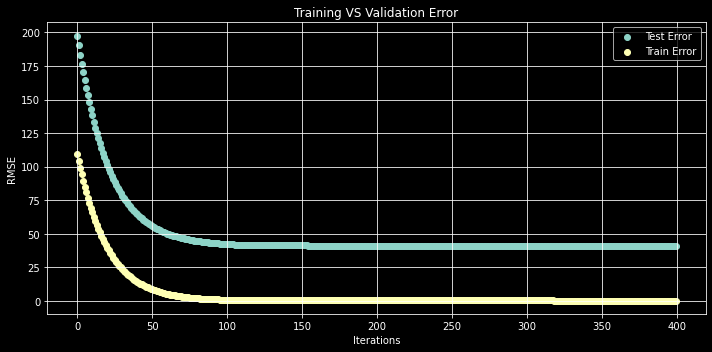

In [51]:
eval_result = best['model'].evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(training_rounds, eval_result['validation_0']['rmse'], label='Test Error')
plt.scatter(training_rounds, eval_result['validation_1']['rmse'], label='Train Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

## Custom Loss Function

In [52]:
def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix):
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [53]:
regressor = xgb.XGBRegressor(n_estimators=400, base_score=0.7, colsample_bytree=1, learning_rate=0.05)
xgbModel = regressor.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], eval_metric=rmsle)

[0]	validation_0-rmse:197.61539	validation_1-rmse:109.78468	validation_0-PyRMSLE:3.08381	validation_1-PyRMSLE:2.74481
[1]	validation_0-rmse:190.35637	validation_1-rmse:104.32039	validation_0-PyRMSLE:2.50818	validation_1-PyRMSLE:2.19834
[2]	validation_0-rmse:183.49554	validation_1-rmse:99.12865	validation_0-PyRMSLE:2.16206	validation_1-PyRMSLE:1.86204
[3]	validation_0-rmse:176.85947	validation_1-rmse:94.19479	validation_0-PyRMSLE:1.91289	validation_1-PyRMSLE:1.62199
[4]	validation_0-rmse:170.68617	validation_1-rmse:89.50768	validation_0-PyRMSLE:1.72628	validation_1-PyRMSLE:1.43735
[5]	validation_0-rmse:164.69789	validation_1-rmse:85.05360	validation_0-PyRMSLE:1.57346	validation_1-PyRMSLE:1.28883
[6]	validation_0-rmse:158.96234	validation_1-rmse:80.82070	validation_0-PyRMSLE:1.44619	validation_1-PyRMSLE:1.16563
[7]	validation_0-rmse:153.34634	validation_1-rmse:76.79940	validation_0-PyRMSLE:1.33553	validation_1-PyRMSLE:1.06115
[8]	validation_0-rmse:148.17165	validation_1-rmse:72.97784	val

[71]	validation_0-rmse:46.52002	validation_1-rmse:2.98948	validation_0-PyRMSLE:0.23983	validation_1-PyRMSLE:0.02561
[72]	validation_0-rmse:46.25528	validation_1-rmse:2.84583	validation_0-PyRMSLE:0.23819	validation_1-PyRMSLE:0.02437
[73]	validation_0-rmse:46.01279	validation_1-rmse:2.70945	validation_0-PyRMSLE:0.23669	validation_1-PyRMSLE:0.02319
[74]	validation_0-rmse:45.79813	validation_1-rmse:2.58015	validation_0-PyRMSLE:0.23536	validation_1-PyRMSLE:0.02208
[75]	validation_0-rmse:45.56475	validation_1-rmse:2.45752	validation_0-PyRMSLE:0.23392	validation_1-PyRMSLE:0.02103
[76]	validation_0-rmse:45.34273	validation_1-rmse:2.34109	validation_0-PyRMSLE:0.23256	validation_1-PyRMSLE:0.02003
[77]	validation_0-rmse:45.15375	validation_1-rmse:2.23076	validation_0-PyRMSLE:0.23139	validation_1-PyRMSLE:0.01908
[78]	validation_0-rmse:44.96325	validation_1-rmse:2.12608	validation_0-PyRMSLE:0.23023	validation_1-PyRMSLE:0.01819
[79]	validation_0-rmse:44.77881	validation_1-rmse:2.02675	validation_0-P

[142]	validation_0-rmse:41.30254	validation_1-rmse:0.41881	validation_0-PyRMSLE:0.20803	validation_1-PyRMSLE:0.00392
[143]	validation_0-rmse:41.29845	validation_1-rmse:0.41678	validation_0-PyRMSLE:0.20800	validation_1-PyRMSLE:0.00390
[144]	validation_0-rmse:41.29486	validation_1-rmse:0.41483	validation_0-PyRMSLE:0.20798	validation_1-PyRMSLE:0.00388
[145]	validation_0-rmse:41.29067	validation_1-rmse:0.41315	validation_0-PyRMSLE:0.20796	validation_1-PyRMSLE:0.00387
[146]	validation_0-rmse:41.28713	validation_1-rmse:0.41109	validation_0-PyRMSLE:0.20794	validation_1-PyRMSLE:0.00385
[147]	validation_0-rmse:41.28272	validation_1-rmse:0.40925	validation_0-PyRMSLE:0.20791	validation_1-PyRMSLE:0.00384
[148]	validation_0-rmse:41.27926	validation_1-rmse:0.40738	validation_0-PyRMSLE:0.20789	validation_1-PyRMSLE:0.00382
[149]	validation_0-rmse:41.27511	validation_1-rmse:0.40626	validation_0-PyRMSLE:0.20786	validation_1-PyRMSLE:0.00380
[150]	validation_0-rmse:41.27204	validation_1-rmse:0.40507	valid

[213]	validation_0-rmse:41.16364	validation_1-rmse:0.34778	validation_0-PyRMSLE:0.20720	validation_1-PyRMSLE:0.00319
[214]	validation_0-rmse:41.16352	validation_1-rmse:0.34734	validation_0-PyRMSLE:0.20720	validation_1-PyRMSLE:0.00319
[215]	validation_0-rmse:41.16233	validation_1-rmse:0.34686	validation_0-PyRMSLE:0.20719	validation_1-PyRMSLE:0.00318
[216]	validation_0-rmse:41.15738	validation_1-rmse:0.34655	validation_0-PyRMSLE:0.20717	validation_1-PyRMSLE:0.00318
[217]	validation_0-rmse:41.15717	validation_1-rmse:0.34516	validation_0-PyRMSLE:0.20716	validation_1-PyRMSLE:0.00317
[218]	validation_0-rmse:41.15705	validation_1-rmse:0.34386	validation_0-PyRMSLE:0.20716	validation_1-PyRMSLE:0.00316
[219]	validation_0-rmse:41.15698	validation_1-rmse:0.34318	validation_0-PyRMSLE:0.20716	validation_1-PyRMSLE:0.00315
[220]	validation_0-rmse:41.15202	validation_1-rmse:0.34302	validation_0-PyRMSLE:0.20713	validation_1-PyRMSLE:0.00315
[221]	validation_0-rmse:41.15181	validation_1-rmse:0.34168	valid

[284]	validation_0-rmse:41.12026	validation_1-rmse:0.30118	validation_0-PyRMSLE:0.20695	validation_1-PyRMSLE:0.00274
[285]	validation_0-rmse:41.11961	validation_1-rmse:0.30093	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00274
[286]	validation_0-rmse:41.11946	validation_1-rmse:0.30011	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00273
[287]	validation_0-rmse:41.11950	validation_1-rmse:0.29926	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00273
[288]	validation_0-rmse:41.11949	validation_1-rmse:0.29872	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00272
[289]	validation_0-rmse:41.11926	validation_1-rmse:0.29808	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00271
[290]	validation_0-rmse:41.11917	validation_1-rmse:0.29756	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00271
[291]	validation_0-rmse:41.11895	validation_1-rmse:0.29724	validation_0-PyRMSLE:0.20694	validation_1-PyRMSLE:0.00271
[292]	validation_0-rmse:41.11892	validation_1-rmse:0.29599	valid

[355]	validation_0-rmse:41.08861	validation_1-rmse:0.26177	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00237
[356]	validation_0-rmse:41.08860	validation_1-rmse:0.26147	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00237
[357]	validation_0-rmse:41.08819	validation_1-rmse:0.26079	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00236
[358]	validation_0-rmse:41.08837	validation_1-rmse:0.26007	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00236
[359]	validation_0-rmse:41.08841	validation_1-rmse:0.25933	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00235
[360]	validation_0-rmse:41.08854	validation_1-rmse:0.25877	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00234
[361]	validation_0-rmse:41.08878	validation_1-rmse:0.25775	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00233
[362]	validation_0-rmse:41.08880	validation_1-rmse:0.25766	validation_0-PyRMSLE:0.20676	validation_1-PyRMSLE:0.00233
[363]	validation_0-rmse:41.08866	validation_1-rmse:0.25696	valid

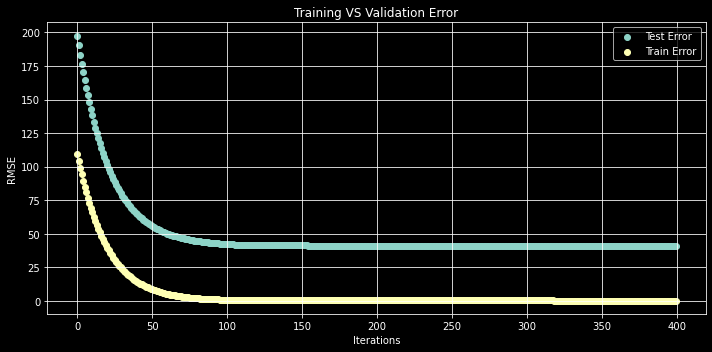

In [54]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(training_rounds, eval_result['validation_0']['rmse'], label='Test Error')
plt.scatter(training_rounds, eval_result['validation_1']['rmse'], label='Train Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

# GridSearch Class

In [55]:
import itertools
import sys

class GridSearch:
    def __init__(self, model, loss_fn, eval_fn, train, test):
        """
        Args:
            model_defn: Any  A model with a .fit() and .predict() function
            loss_fn: Function A function to pass to .fit() to optimise on
            eval_fn: Function A function that specifies how to determine the best model to save
            train: Tuple A tuple containing the X_train and y_train
            test: Tuple A tuple containing the X_test and y_test
        """
        self.model_defn = model
        self.loss_fn = loss_fn
        self.X_train, self.y_train = train
        self.X_test, self.y_test = test
        self.best = {"model": None, "loss": sys.float_info.max, "params": {}}
        self.eval_fn = eval_fn

    def test_hyperparams(self, params_dict):
        params = self.params_perms(params_dict)
        keys = params_dict.keys()
        for param in params:
            init_args = {k:v for k,v in zip(keys, param)}

            model = self.model_defn(**init_args)
            model.fit(self.X_train, self.y_train, 
                      eval_set=[(self.X_test, self.y_test), (self.X_train, self.y_train)], 
                      eval_metric=self.loss_fn, verbose=False)
            
            pred = model.predict(X_test)
            loss = self.eval_fn(pred, y_test)
            if loss < self.best['loss']:
                self.best['loss'] = loss
                self.best["params"] = init_args
                self.best['model'] = model

    def params_perms(self, params_dict):
        return list(itertools.product(*parameters.values()))

In [56]:
def rmsle_xgboost(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

def rmsle(y_pred, y_true):
    y_pred[y_pred < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y_true) - np.log1p(y_pred), 2)
    return float(np.sqrt(np.sum(elements) / len(y_true)))

def get_rmsle_from_model(model):
    return model.evals_result()['validation_0']['rmse'][-1]

In [57]:
gs = GridSearch(xgb.XGBRegressor, rmsle_xgboost, rmsle, (X_train, y_train), (X_test, y_test))

In [58]:
parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.05], 'n_estimators': [100, 200, 300, 400], 'max_depth': [8, 10, 12, 15]}
gs.test_hyperparams(parameters)

In [59]:
model = gs.best["model"]

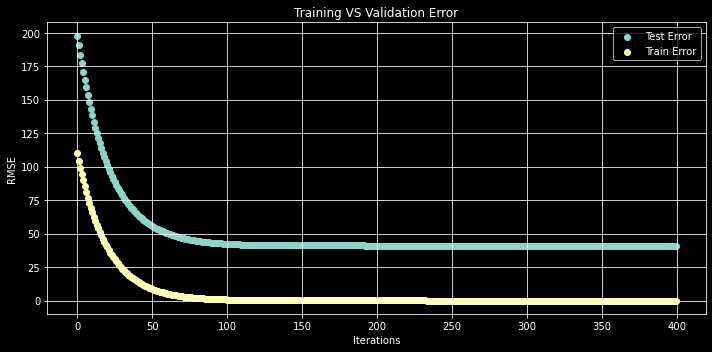

In [60]:
eval_result = model.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(training_rounds, eval_result['validation_0']['rmse'], label='Test Error')
plt.scatter(training_rounds, eval_result['validation_1']['rmse'], label='Train Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

# Notes:

1. Exception/Error handling
1. Subplots 
1. .py's

## Exceptions & Errors

`x` is not defined - notice the type of Error (`NameError`)

In [7]:
x

NameError: name 'x' is not defined

To catch errors, we can use the `try` and `except` syntax

In [1]:
try:
    print(x)
except:
    print("There was an error")

There was an error


Write a function that takes a list of numbers and adds one to each element. If it cannot, then it catches the error and prints out the offending items index

In [22]:
arr = [1,2,"hullabaloo",4]
def must_be_int(arr):
    for idx,_ in enumerate(arr):
        try:
            arr[idx] = arr[idx] + 1
        except:
            print(f"item {idx} is not a number!")
must_be_int(arr)
arr

item 2 is not a number!


[2, 3, 'hullabaloo', 5]

`except NameError` is used to catch specific types of errors (see list here https://docs.python.org/3/library/exceptions.html)

In [3]:
try:
    print(x)
except NameError:
    print("Variable x is not defined")
except:
    print("Something else went wrong") 

Variable x is not defined


Rewrite the function earlier to catch TypeErrors and returns those in a separate array

In [34]:
arr = [1,2,"hullabaloo",4]
def must_be_int(arr):
    type_error_arr = []
    for idx,_ in enumerate(arr):
        try:
            arr[idx] = arr[idx] + 1
        except TypeError:
            type_error_arr.append(arr[idx])
        except:
            print(f"item {idx} triggered an error we didn't expect!")
    return type_error_arr
type_error_arr = must_be_int(arr)
arr, type_error_arr

([2, 3, 'hullabaloo', 5], ['hullabaloo'])

`else` is used if you want something to run if no error is caught

In [6]:
try:
    print("Hello")
except:
    print("Something went wrong")
else:
    print("Nothing went wrong") 

Hello
Nothing went wrong


Write a function that converts a list of strings into their symbolic representations (eg. using `eval`) and prints out the list if successful but prints out an error message if a single one fails to `eval`

In [42]:
should_print = ['[1,2,3]', '{0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}']
should_not_print = ['[1,2,3]', '{0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}', "hullabaloo"]

def eval_print(arr):
    success_arr = []
    all_success = True
    for i in arr:
        try:
            success_arr.append(eval(i))
        except:
            all_success = False
    if all_success:
        print(success_arr)
    else:
        print("There was an error!")

In [43]:
eval_print(should_print)

[[1, 2, 3], {0: [1, 2, 3], 1: [2, 3, 4], 2: [3, 4, 5]}]


In [44]:
eval_print(should_not_print)

There was an error!


`finally` is used to always call a block regardless of whether an error is raised or not

In [8]:
try:
    print(x)
except:
    print("Something went wrong")
finally:
    print("The 'try except' is finished") 

Something went wrong
The 'try except' is finished


Modify the function above to print out the items in the list as it iterates through it regardless of whether an exception is raised or not 

In [47]:
def eval_print(arr):
    success_arr = []
    all_success = True
    for i in arr:
        try:
            success_arr.append(eval(i))
        except:
            all_success = False
        finally:
            print(f"Item in queue: {i}") 
    if all_success:
        print(success_arr)
    else:
        print("There was an error!")

In [48]:
eval_print(should_not_print)

Item in queue: [1,2,3]
Item in queue: {0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}
Item in queue: hullabaloo
There was an error!


Modify the function such that it tries to append the number 8 to an item in the list it just evaluated. If that failed, then have it print out the offending item.

In [50]:
def eval_print(arr):
    success_arr = []
    all_success = True
    for i in arr:
        try:
            success_arr.append(eval(i))
            try:
                success_arr[-1].append(8)
            except:
                print(f"Could not append the number 8 to item {i}")
        except:
            all_success = False
        finally:
            print(f"Item in queue: {i}") 
    if all_success:
        print(success_arr)
    else:
        print("There was an error!")

In [52]:
eval_print(should_print)

Item in queue: [1,2,3]
Could not append the number 8 to item {0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}
Item in queue: {0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}
[[1, 2, 3, 8], {0: [1, 2, 3], 1: [2, 3, 4], 2: [3, 4, 5]}]


In [51]:
eval_print(should_not_print)

Item in queue: [1,2,3]
Could not append the number 8 to item {0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}
Item in queue: {0: [1,2,3], 1: [2,3,4], 2: [3,4,5]}
Item in queue: hullabaloo
There was an error!


Writing our own errors - we can choose to raise our own errors

In [ ]:
x = "hello"

if not type(x) is int:
    raise TypeError("Only integers are allowed") 

Write a function called square root that returns the square root of a number if is 0 or greater but raises an exception if it is not

In [10]:
import numpy as np

def sqrt(x):
    if x >= 0:
        return np.sqrt(x)
    else:
        raise Exception("x must be 0 or greater") 

In [14]:
sqrt(0)

0.0

In [12]:
sqrt(-1)

Exception: Sorry, no numbers below zero